In [ ]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [78]:
# 从 Excel 文件读取数据
df = pd.read_excel('data.xlsx')

# 提取列数据
u1_data = df['u1'].values[0:402]
u2_data = df['u2'].values[0:402]
y1_data = df['y1'].values[0:402]
y2_data = df['y2'].values[0:402]

# # 输出提取的数据
# print('u1_data:', u1_data.shape)
# print('u2_data:', u2_data.shape)
# print('y1_data:', y1_data.shape)
# print('y2_data:', y1_data.shape)

num_samples = y1_data.shape[0]


In [79]:
# 组合训练数据  多输入双输出
# 假设有训练数据 u1_data, u2_data, y1_data 和 y1_data+1
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
# 1 |2| 3 4 5 6 
# 6 |1| 2 3 4 5
# 1 |2| 3 4 5 6 

u1_data = u1_data
u2_data = u2_data

u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0

y1_data = y1_data
y2_data = y2_data

X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1],
                        u1_data_1[1:-1], u2_data_1[1:-1],
                        y1_data  [1:-1], y2_data  [1:-1])
                    )
y = np.column_stack((y1_data[2:],y2_data[2:]))

# 使用 reshape 转换形状
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
y_reshaped = y.reshape((y.shape[0], 1, y.shape[1]))

print(X.shape,y.shape)
print(X_reshaped.shape,y_reshaped.shape)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                    test_size=0.5, 
                                                    random_state=42, 
                                                    shuffle=True)

# # 计算划分点
# split_point = int(len(X_reshaped) * (1 - 0.05))
# # 划分数据集
# X_train, X_test = X_reshaped[:split_point], X_reshaped[split_point:]
# y_train, y_test = y_reshaped[:split_point], y_reshaped[split_point:]



y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(400, 6) (400, 2)
(400, 1, 6) (400, 1, 2)
(200, 1, 6) (200, 2)
(200, 1, 6) (200, 2)


In [80]:
# 定义模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,hidden_size):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=6,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(2*hidden_size, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse

    def my_fit(self, X_train, y_train, epochs=1, batch_size=32):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        loss_list = []

        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_loss = epoch_loss / (len(X_train) // batch_size + 1)
            print(f'第 {epoch + 1}/{epochs} 轮, 误差: {average_epoch_loss:.4f}', end='\r')
            loss_list.append(average_epoch_loss)

        return loss_list

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [81]:
# 创建模型实例
hidden_size = 64
model = MyRNNModel(hidden_size)
epoch_sum = 0



In [82]:
# 训练-预测-RMSE、MRE-命中率曲线
epoch_once = 100
epoch_sum = epoch_sum+epoch_once
loss_history = model.my_fit(X_train, y_train, epochs=epoch_once, batch_size=32)
print('\nepoch_sum:',epoch_sum)


第 100/100 轮, 误差: 0.0573
epoch_sum: 100


输出0: RMSE:0.3289,MRE:61.5172
输出1: RMSE:0.2230,MRE:41.0946
误差分析0:平均值:0.3246,方差:0.0534
误差分析1:平均值:0.2226,方差:0.0129


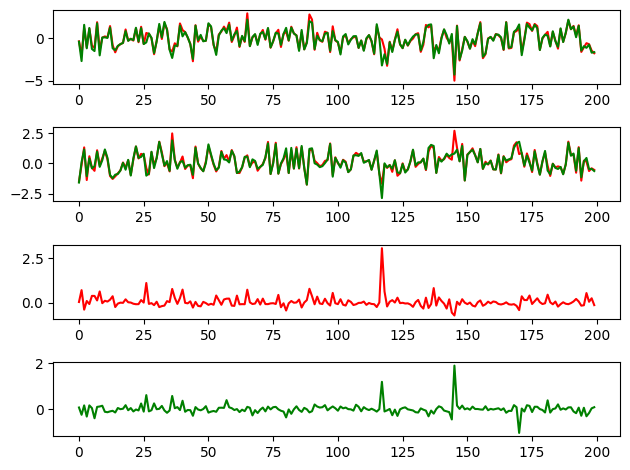

In [83]:
y_pred_0,y_pred_1  = model.my_predict(X_test)
# 计算 RMSE、MRE
y_test0 = y_test



y_test_0 = y_test0[:, 0]
y_test_1 = y_test0[:, 1]
y_pred_0_inverse_transform =y_pred_0
y_pred_1_inverse_transform = y_pred_1

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果
print(f"输出0: RMSE:{rmse_0:.4f},MRE:{mre_0:.4f}")
print(f"输出1: RMSE:{rmse_1:.4f},MRE:{mre_1:.4f}")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')


plt.tight_layout()
plt.show()


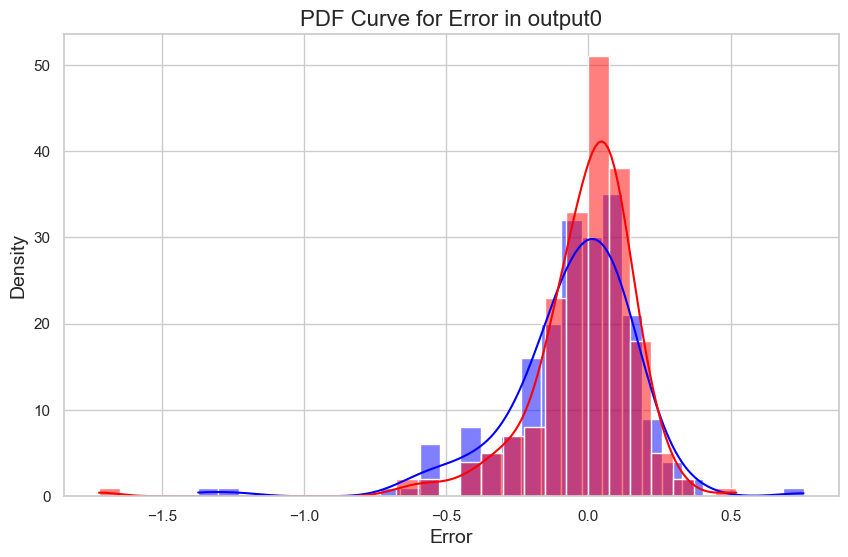

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 使用 Seaborn 绘制误差的概率密度函数曲线
# sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(output0, kde=True, color="blue", bins=30)
sns.histplot(output1, kde=True, color="red", bins=30)
plt.title("PDF Curve for Error in output0", fontsize=16)
plt.xlabel("Error", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()


In [85]:
# 创建模型实例
hidden_size = 64
model_gaolu = MyRNNModel(hidden_size)
epoch_sum_gaolu = 0



输出0: RMSE:0.2456,MRE:0.5437,MAPE:54.3748%
输出1: RMSE:0.2064,MRE:0.4942,MAPE:38.4099%
误差分析0:平均值:0.2391,方差:-0.0563
误差分析1:平均值:0.2058,方差:-0.0163


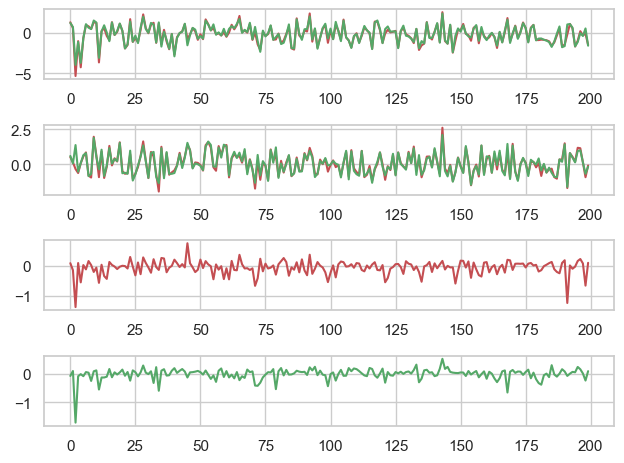

In [102]:
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_train)

# 计算 RMSE、MRE
y_test0 = y_train

y_test_0 = y_test0[:, 0]
y_test_1 = y_test0[:, 1]
y_pred_0_inverse_transform =y_pred_0
y_pred_1_inverse_transform = y_pred_1

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) 
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) 
mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_0)) * 100
# 打印结果
print(f"输出0: RMSE:{rmse_0:.4f},MRE:{mre_0:.4f},MAPE:{mape_0:.4f}%")
print(f"输出1: RMSE:{rmse_1:.4f},MRE:{mre_1:.4f},MAPE:{mape_1:.4f}%")


# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')


plt.tight_layout()
plt.show()


In [ ]:
# 提取参数
model_params = model.state_dict()

# 查看参数字典的键
print(model_params.keys())

# 查看数组的形状
for key, value in model_params.items():
    print(f"{key}: {value.shape}")


In [ ]:
# 自定义预测
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lstm_forward(input, initial_states, w_ih, w_hh, b_ih, b_hh):
    h_0, c_0 = initial_states  # 初始状态  [b_size, hidden_size]
    b_size, seq_len, input_size = input.shape
    h_size = h_0.shape[-1]

    h_prev, c_prev = h_0, c_0

    # 使用 np.newaxis 在第一个维度上插入一个新的维度  # 使用 np.tile 在第一个维度上复制 b_size 次
    w_ih_expanded = w_ih[np.newaxis, :, :]    
    w_ih_batch = np.tile(w_ih_expanded, (b_size, 1, 1))
    w_hh_expanded = w_hh[np.newaxis, :, :]    
    w_hh_batch = np.tile(w_hh_expanded, (b_size, 1, 1))
    # print(w_ih_batch.shape)

    output_size = h_size
    output = np.zeros((b_size, seq_len, output_size))  # 初始化一个输出序列
    for t in range(seq_len):
        x = input[:, t, :]  # 当前时刻的输入向量 [b,in_size]->[b,in_size,1]
        w_times_x = np.matmul(w_ih_batch, x[:, :, np.newaxis]).squeeze(-1)   # bmm:含有批量大小的矩阵相乘
        # [b, 4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Wii*xt|Wif*xt|Wig*xt|Wio*xt
        w_times_h_prev = np.matmul(w_hh_batch, h_prev[:, :, np.newaxis]).squeeze(-1)
        # [b, 4*hidden_size, hidden_size]*[b, hidden_size, 1]->[b,4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Whi*ht-1|Whf*ht-1|Whg*ht-1|Who*ht-1

        # 分别计算输入门(i)、遗忘门(f)、cell门(g)、输出门(o)  维度均为 [b, h_size]
        i_t = sigmoid(w_times_x[:, :h_size] + w_times_h_prev[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])  # 取前四分之一
        f_t = sigmoid(w_times_x[:, h_size:2*h_size] + w_times_h_prev[:, h_size:2*h_size]
                            + b_ih[h_size:2*h_size] + b_hh[h_size:2*h_size])
        g_t = np.tanh(w_times_x[:, 2*h_size:3*h_size] + w_times_h_prev[:, 2*h_size:3*h_size]
                            + b_ih[2*h_size:3*h_size] + b_hh[2*h_size:3*h_size])
        o_t = sigmoid(w_times_x[:, 3*h_size:] + w_times_h_prev[:, 3*h_size:]
                            + b_ih[3*h_size:] + b_hh[3*h_size:])
        c_prev = f_t * c_prev + i_t * g_t
        h_prev = o_t * np.tanh(c_prev)

        output[:, t, :] = h_prev

    return output, (np.expand_dims(h_prev, axis=0), np.expand_dims(c_prev, axis=0))  # 官方是三维，在第0维扩一维



def predict_my(data_input):

    input = data_input  # 随机初始化一个输入序列
    c_0 = np.zeros((data_input.shape[0], hidden_size))  # 初始值，不会参与训练
    h_0 = np.zeros((data_input.shape[0], hidden_size))

    output_forward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model.lstm.weight_ih_l0.detach().numpy(),
                                                model.lstm.weight_hh_l0.detach().numpy(), 
                                                model.lstm.bias_ih_l0.detach().numpy(), 
                                                model.lstm.bias_hh_l0.detach().numpy())

    last_lstm_output_forward = output_forward[:, -1, :]

    output_backward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model.lstm.weight_ih_l0_reverse.detach().numpy(),
                                                model.lstm.weight_hh_l0_reverse.detach().numpy(), 
                                                model.lstm.bias_ih_l0_reverse.detach().numpy(), 
                                                model.lstm.bias_hh_l0_reverse.detach().numpy())

    last_lstm_output_backward = output_backward[:, -1, :]
    # print(last_lstm_output_forward.shape)
    # print(last_lstm_output_backward.shape)
    # 最终输出
    combined_hidden = np.concatenate((last_lstm_output_forward, last_lstm_output_backward), axis=1)
    # print(combined_hidden.shape)


    output = (np.dot(combined_hidden, np.transpose(model.fc.weight.detach().numpy()))
                + model.fc.bias.detach().numpy()
)
    y_pred_0, y_pred_1= output[:,0],output[:,1]

    # y_pred_0 = scalers[output_term[0]].inverse_transform(np.array(y_pred_0).reshape(-1, 1)).flatten()
    # y_pred_1 = scalers[output_term[1]].inverse_transform(np.array(y_pred_1).reshape(-1, 1)).flatten()




    return y_pred_0, y_pred_1


y_pred_0, y_pred_1= predict_my(X_test)


# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)
# plot_hit_rate_curve(y_test, y_pred_0.detach().numpy(), y_pred_1.detach().numpy())





In [ ]:
y_pred_0, y_pred_1= predict_my(X_train)

# 计算 RMSE、MRE
y_test0 = y_train

y_test_0 = y_test0[:, 0]
y_test_1 = y_test0[:, 1]
y_pred_0_inverse_transform =y_pred_0
y_pred_1_inverse_transform = y_pred_1

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果
print(f"输出0: RMSE:{rmse_0:.4f},MRE:{mre_0:.4f}")
print(f"输出1: RMSE:{rmse_1:.4f},MRE:{mre_1:.4f}")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')


plt.tight_layout()
plt.show()


In [ ]:
# 差分方程  # 生成数据
def nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1):
    # 生成噪声
    noise_level = 0.01
    noise1 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    noise2 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    # 计算输出
    output1 = y1_k / (1 + y2_k**2) + u1_k + 0.2 * u2_k + 0.4 * u1_k_1 + 0.1 * u2_k_1 
    output2 = y1_k * y2_k / (1 + y2_k**2) + 0.3 * u1_k + u2_k + 0.1 * u1_k_1 + 0.5 * u2_k_1
    # return output1 + noise1, output2 + noise2
    return output1 + noise1, output2 + noise2 ,noise1 ,noise2
    # return output1, output2,noise1,noise2


In [ ]:
# 生成期望数据
Times = 100

def generate_y_aim_data(Times):
    set_y1 = np.full(Times, 0.4)
    set_y1[40:] = 0.6
    # set_y1[90:] = -0.1
    # set_y1[130:151] = 0.0
    # set_y1[170:201] = 0.4
    # set_y1[185] = -0.7  # 添加脉冲干扰

    set_y2 = np.full(Times, 0.2)
    set_y2[70:] = 0.3
    # set_y2[90:] = 0.5
    # set_y2[150:] = -0.7  # 添加脉冲干扰
    # set_y2[200:] = 0.4

    # 限制设定值在 -1 到 1 之间
    # set_y1 = np.clip(set_y1, -1, 1)
    # set_y2 = np.clip(set_y2, -1, 1)

    return set_y1, set_y2



# # 调用示例
# set_y1, set_y2 = generate_y_aim_data(Times)
# plt.plot(set_y1)
# plt.plot(set_y2)
# plt.title('y_sp')
# plt.show()



In [ ]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
y_r = get_yr(1,-0.5,0.667,5+1)


In [ ]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, y1_data, num_samples, P):
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = 181  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+2  ]
    u2   = u2_data[randint  :randint+2  ]
    u1_1 = u1_data[randint-1:randint+2-1]
    u2_1 = u2_data[randint-1:randint+2-1]
    y1   = y1_data[randint  :randint+2  ]
    y2   = y2_data[randint  :randint+2  ]
    k_data = np.concatenate((u1, u2, u1_1, u2_1, y1, y2), axis=0)
    # print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data



In [104]:
# 原有   定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim):
    lamda1 = 1
    lamda2 = 1
    # 从固定格式k_data里面读取信息
    u1   = k_data[0:2]
    u2   = k_data[2:4]
    u1_1 = k_data[4:6]
    u2_1 = k_data[6:8]
    y1   = k_data[8:10]
    y2   = k_data[10:12]
    # 获取猜测值[h U1 U2]
    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    U1, U2  =params[0:M], params[M:2*M]
    h = 1.0
    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1[:1],U1))
    u2   = np.concatenate((u2[:1],U2))
    u1_1 = np.concatenate((u1_1[:2],U1[:-1]))
    u2_1 = np.concatenate((u2_1[:2],U2[:-1]))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    y1_k = y1[1]
    y2_k = y2[1]
    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)
    # print(y2)
    # print(y1_k)    
    # print(y2_k)

    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k,y2_m_k = predict_my(x)
        # y1[j+1] = y1_m_k.item()###############################是否替换不知道有没有影响？
        # y2[j+1] = y2_m_k.item()###############################
        # 在k时刻，我要先通过k-1时刻来预测出当前k时刻下的预测值。
        # 实际上，这个时候我有k时刻的真实值。
        # 但是这么做是为了能够获取我的预测值和真实值之间的误差，
        # 然后基于这个误差，通过对控制器输入的调整来预测k+1时刻，
        # 然后依次往下。因此，在k时刻，我系统的值是固定的，
        # 也就是我的真实值，所以我要把它存储到我的整体的一个序列里面。
        # 在取出当前k时刻真实值的过程中，我不能将之前预测的时候的那个
        # 预测值覆盖掉真实值。后面新预测的数值要加上前面的那一个误差
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k

    # 对每个U对应的控制时刻进行预测-----M次
    for j in range(1,M+1):  
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j,y2_k_j = predict_my(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):
        x = np.column_stack((u1[-1],u2[-1],u1[-1],u2[-1],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j,y2_k_j = predict_my(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()

    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)
    # print(y2)
    # print(y1_k)    
    # print(y2_k)
    # print('2222222222222222222')
        

    #和获取参考轨迹
    # 一定要对照好做差的序列
    y_r  = get_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y_r[1:] 
    # print('y1_aim',y1_aim)
    # print('y_r',y_r)


    y_r  = get_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y_r[1:] 
    # print('y2_aim',y2_aim)
    # print('y_r',y_r)

    y1_M_k = y1[2:]
    y2_M_k = y2[2:]
    # print('y1',y1)
    # print('h*E1_k',h*E1_k)
    # print('y2',y2)
    # print('h*E2_k',h*E2_k)



    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙


    mse = (0
            # +loss_function(y1_r, y1_M_k+h*E1_k, weights)
            # +loss_function(y2_r, y2_M_k+h*E2_k, weights)
            # +(np.abs(y1_aim-y1_k)**2+np.abs(y2_aim-y2_k)**2)*P*2000
            +np.sum((y1_r-y1_M_k-h*E1_k)**2 + (y2_r-y2_M_k-h*E2_k)**2)
            +np.sum(lamda1*(np.diff(u1)**2))
            +np.sum(lamda2*(np.diff(u2)**2))


            )
    # print('mse {:.7f}'.format(mse))
    k_data2 = np.concatenate((u1[1:3],u2[1:3],u1_1[1:3],u2_1[1:3],y1[1:3],y2[1:3]),axis=0)

    return mse , k_data2


In [105]:
# 原有   对未来Times周期预测控制
# 期望设定值
set_y1 , set_y2 = generate_y_aim_data(Times)
# MPC参数
P = 3  # 预测时域长度
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, y1_data, num_samples, P)

# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_noise1  = []
all_pred_noise2 = []
# all_pred_y1.append(y1_data[1])
# all_pred_y2.append(y2_data[1])
# MPC控制循环
for k in range(100):
    print(f"这是对第{k}时刻的最优U1、U2输入求解")
    # print('y1_aim  y2_aim',set_y1[k],set_y2[k])
    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2 = my_MPC(k_data=k_data[0], params=params, M=M, P=P, y1_aim = set_y1[k], y2_aim = set_y2[k])  
        return mse

    # 初始猜测值[h U1 U2]
    params = np.concatenate([np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(-1, 1) for _ in range(2 * M)]
    # 进行优化
    # 设置退出条件
    options = {'gtol': 1e-3}

    # 调用 minimize 函数
    result = minimize(objective_function, params, method='L-BFGS-B', bounds=bounds, args=k_data, options=options)

    # result = minimize(objective_function, params, method='L-BFGS-B', 
    #                 bounds=bounds, args=k_data)#args传进来的是一个元组
    # # 查看退出条件
    # if result.success:
    #     print("优化成功收敛!")
    # else:
    #     print("优化未成功收敛。")
    #     # 打印其他结果信息
    # print("最优参数:", result.x)
    # print("最优函数值:", result.fun)
    # print("迭代次数:", result.nit)
    # print("Gradient:", result.jac)
    # optimized_h, optimized_U1, optimized_U2 = result.x[0], result.x[1:M+1], result.x[M+1:]
    optimized_U1, optimized_U2 = result.x[0:M], result.x[M:]
    # print('optimized_h, optimized_U1, optimized_U2',optimized_h, optimized_U1, optimized_U2)

    # 获取当前时刻下，在最优的U1、U2下的响应    
    u1_k = optimized_U1[0]
    u2_k = optimized_U2[0]
    u1_k_1 = k_data[5]
    u2_k_1 = k_data[7]
    y1_k = k_data[9] 
    y2_k = k_data[11] 

    x = np.column_stack((u1_k,u2_k,u1_k_1,u2_k_1,y1_k,y2_k))
    x = x.reshape((x.shape[0], 1, x.shape[1]))
    y1_pred, y2_pred = model_gaolu.my_predict(x)

    

    # y1_pred, y2_pred,noise1 ,noise2= nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1)
    # print(noise1)
    # all_pred_noise1.append(noise1)
    # all_pred_noise2.append(noise2)
    # print("666666666666")
    # 获取当前时刻下，在最优的U1、U2下的响应
    params = np.concatenate((optimized_U1,optimized_U2),axis=0)
    mse, k_data2 =my_MPC(k_data=k_data,params=params,M=M,P=P, y1_aim = set_y1[k], y2_aim = set_y2[k]) 
    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(u1_k)
    all_pred_u2.append(u2_k)
    k_data2[9]  = y1_pred
    k_data2[11] = y2_pred
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


181
这是对第0时刻的最优U1、U2输入求解
这是对第1时刻的最优U1、U2输入求解
这是对第2时刻的最优U1、U2输入求解


C:\Users\haokw\AppData\Local\Temp\ipykernel_28448\2221227297.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_data2[9]  = y1_pred
C:\Users\haokw\AppData\Local\Temp\ipykernel_28448\2221227297.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_data2[11] = y2_pred


这是对第3时刻的最优U1、U2输入求解
这是对第4时刻的最优U1、U2输入求解
这是对第5时刻的最优U1、U2输入求解
这是对第6时刻的最优U1、U2输入求解
这是对第7时刻的最优U1、U2输入求解
这是对第8时刻的最优U1、U2输入求解
这是对第9时刻的最优U1、U2输入求解
这是对第10时刻的最优U1、U2输入求解
这是对第11时刻的最优U1、U2输入求解
这是对第12时刻的最优U1、U2输入求解
这是对第13时刻的最优U1、U2输入求解
这是对第14时刻的最优U1、U2输入求解
这是对第15时刻的最优U1、U2输入求解
这是对第16时刻的最优U1、U2输入求解
这是对第17时刻的最优U1、U2输入求解
这是对第18时刻的最优U1、U2输入求解
这是对第19时刻的最优U1、U2输入求解
这是对第20时刻的最优U1、U2输入求解
这是对第21时刻的最优U1、U2输入求解
这是对第22时刻的最优U1、U2输入求解
这是对第23时刻的最优U1、U2输入求解
这是对第24时刻的最优U1、U2输入求解
这是对第25时刻的最优U1、U2输入求解
这是对第26时刻的最优U1、U2输入求解
这是对第27时刻的最优U1、U2输入求解
这是对第28时刻的最优U1、U2输入求解
这是对第29时刻的最优U1、U2输入求解
这是对第30时刻的最优U1、U2输入求解
这是对第31时刻的最优U1、U2输入求解
这是对第32时刻的最优U1、U2输入求解
这是对第33时刻的最优U1、U2输入求解
这是对第34时刻的最优U1、U2输入求解
这是对第35时刻的最优U1、U2输入求解
这是对第36时刻的最优U1、U2输入求解
这是对第37时刻的最优U1、U2输入求解
这是对第38时刻的最优U1、U2输入求解
这是对第39时刻的最优U1、U2输入求解
这是对第40时刻的最优U1、U2输入求解
这是对第41时刻的最优U1、U2输入求解
这是对第42时刻的最优U1、U2输入求解
这是对第43时刻的最优U1、U2输入求解
这是对第44时刻的最优U1、U2输入求解
这是对第45时刻的最优U1、U2输入求解
这是对第46时刻的最优U1、U2输入求解
这是对第47时刻的最优U1、U2输入求解
这是对第48时刻的最优U1、U2输入求解
这是对第49时刻的最优U1、U2输入求解
这是对第50时刻的最优U1、U2输入求解

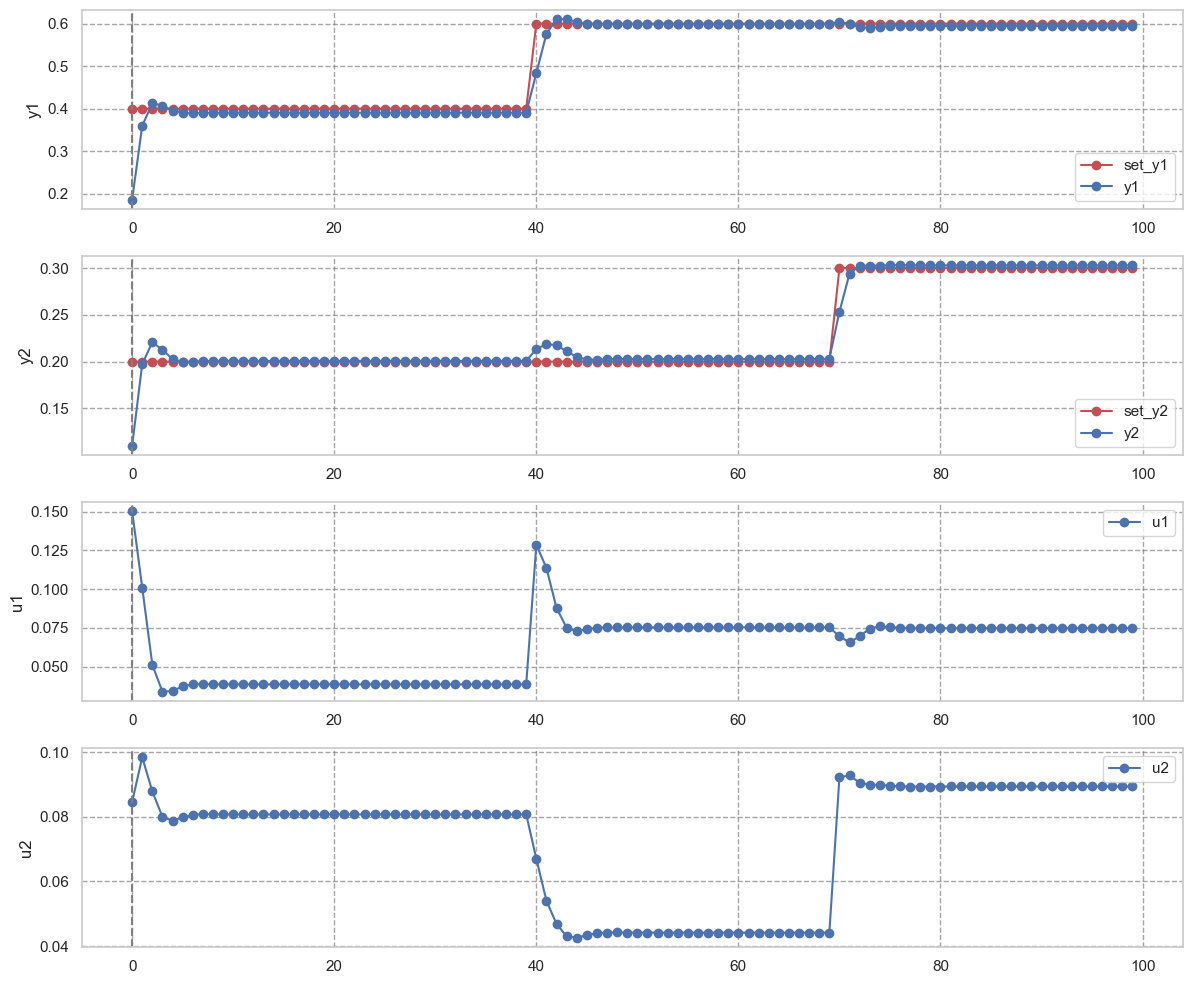

In [106]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 10))

# 第一个维度的曲线
plt.subplot(4, 1, 1)
plt.plot(set_y1, 'ro-', label='set_y1')
plt.plot(np.array(all_pred_y1), 'bo-', label='y1')
plt.plot(np.array(all_pred_y1)-np.array(all_pred_noise1), 'go-', label='y1-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('y1')
# plt.title('Comparison of set_y1 and all_pred_y1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的曲线
plt.subplot(4, 1, 2)
plt.plot(set_y2, 'ro-', label='set_y2')
plt.plot(np.array(all_pred_y2), 'bo-', label='y2')
plt.plot(np.array(all_pred_y2)-np.array(all_pred_noise2), 'go-', label='y2-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('y2')
# plt.title('Comparison of set_y2 and all_pred_y2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第一个维度的u1曲线
plt.subplot(4, 1, 3)
plt.plot(all_pred_u1, 'bo-', label='u1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('u1')
# plt.title('Prediction of all_pred_u1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的u2曲线
plt.subplot(4, 1, 4)
plt.plot(all_pred_u2, 'bo-', label='u2')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('u2')
# plt.title('Prediction of all_pred_u2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 调整子图布局
plt.tight_layout()
plt.show()


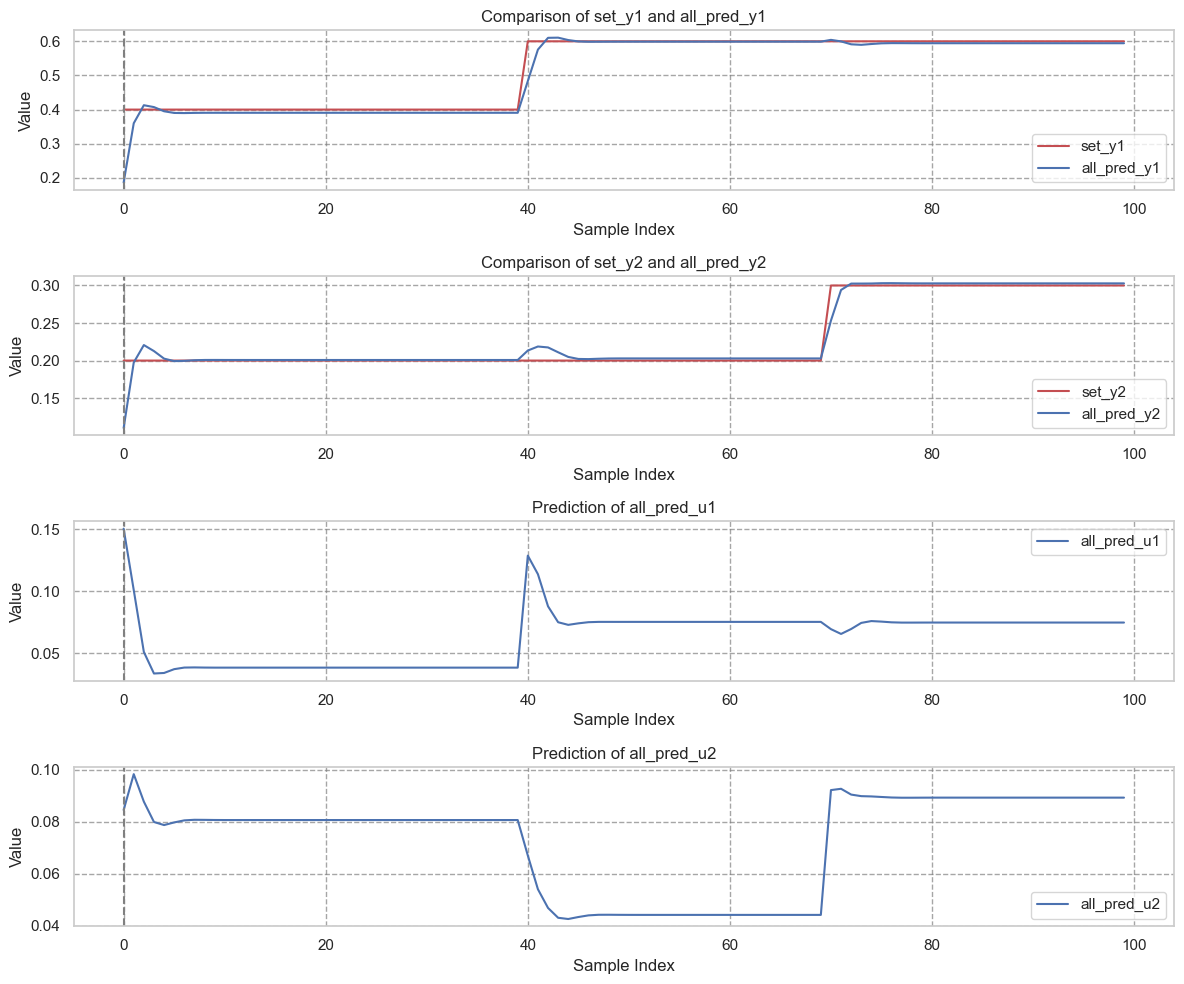

In [107]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 10))

# 第一个维度的曲线
plt.subplot(4, 1, 1)
plt.plot(set_y1, 'r-', label='set_y1')
plt.plot(np.array(all_pred_y1), 'b-', label='all_pred_y1')
plt.plot(np.array(all_pred_y1)-np.array(all_pred_noise1), 'g-', label='all_pred_y1-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of set_y1 and all_pred_y1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的曲线
plt.subplot(4, 1, 2)
plt.plot(set_y2, 'r-', label='set_y2')
plt.plot(np.array(all_pred_y2), 'b-', label='all_pred_y2')
plt.plot(np.array(all_pred_y2)-np.array(all_pred_noise2), 'g-', label='all_pred_y2-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of set_y2 and all_pred_y2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第一个维度的u1曲线
plt.subplot(4, 1, 3)
plt.plot(all_pred_u1, 'b-', label='all_pred_u1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction of all_pred_u1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的u2曲线
plt.subplot(4, 1, 4)
plt.plot(all_pred_u2, 'b-', label='all_pred_u2')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction of all_pred_u2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 调整子图布局
plt.tight_layout()
plt.show()
